In [1]:
import torch
from torch import nn
from utils_torch import *
import utils_torch as ut

# Queries, Keys, and Values

In [5]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

The attention weight is one only when the query and the key are the same.

In [6]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights

tensor([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]])

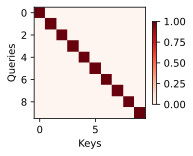

In [7]:
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# Attention Scoring Functions
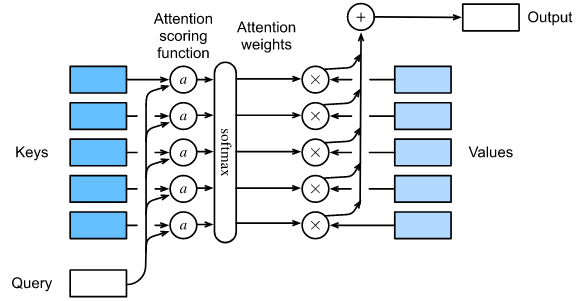

## Dot Product Attention
**Masked Softmax Operation**

In [41]:
def masked_softmax(X, valid_lens):  # @save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Consider a minibatch of two examples of size 2x4, where their valid lengths are 2 and 3, respectively. As a result of the masked softmax operation, values beyond the valid lengths for each pair of vectors are all masked as zero. 

In [42]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4735, 0.5265, 0.0000, 0.0000],
         [0.4085, 0.5915, 0.0000, 0.0000]],

        [[0.3108, 0.3018, 0.3873, 0.0000],
         [0.5032, 0.2870, 0.2098, 0.0000]]])

**Batch Matrix Multiplication**

In [46]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
torch.bmm(Q, K), torch.bmm(Q, K).shape

(tensor([[[4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.]],
 
         [[4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.]]]),
 torch.Size([2, 3, 6]))

## Scaled Dot-Product Attention

In [50]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        score = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(score, valid_lens)
        # use dropout for model regularization.
        return torch.bmm(self.dropout(self.attention_weights), values)

In [51]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2,6])
attention = DotProductAttention(dropout=0.5)
attention.eval()

DotProductAttention(
  (dropout): Dropout(p=0.5, inplace=False)
)

In [52]:
attention(queries,keys,values,valid_lens)

tensor([[[ 1.4447,  0.7294,  1.3259, -0.2836]],

        [[ 1.2102, -0.1294, -0.3294,  0.0323]]])

In [55]:
attention.attention_weights

tensor([[[0.7597, 0.2403, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1251, 0.0855, 0.0598, 0.3352, 0.2576, 0.1368, 0.0000, 0.0000,
          0.0000, 0.0000]]])

The attention weights actually vanish for anything beyond the second and sixth column respectively (due to setting valid length to 2 and 6).

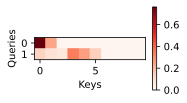

In [56]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Additive Attention

In [ ]:
class AdditiveAttention(nn.Module):
    def __init__(self, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        